<a href="https://colab.research.google.com/github/mahsaghaderan99/DigikalaCommentAnalysis/blob/cnn/comment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation

In [4]:
!pip install stanza -U

Requirement already up-to-date: stanza in /usr/local/lib/python3.6/dist-packages (1.1.1)


#Imports

In [1]:
import stanza
import numpy as np
import pandas as pd 
import string
import cv2
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
import gensim 
from gensim.models import Word2Vec 

In [229]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from keras.callbacks import ModelCheckpoint 
from sklearn.model_selection import train_test_split
import time

#Data preparation

In [ ]:
#Save text file into drive

# !ls /content/drive/MyDrive
# !mkdir /content/drive/MyDrive/digikala
# !cp /content/digikala_dataset.txt /content/drive/MyDrive/digikala

In [2]:
x = []
y = []
with open('/content/drive/MyDrive/digikala/digikala_dataset.txt','r') as f:
  for line in f:
    index = line.find('\t')
    dy = line[:index]
    dx = line[index+1:]
    x.append(dx)
    y.append(dy)


In [4]:
x = np.array(x)
y = np.array(y)

In [28]:
punkts = {
    '!':' ',
    ')':' ',
    '(':' ',
    "'":' ',
    '.':' ',
    ':':' ',
    '-':' ',
    ',':' ',
    '*':' ',
    '/':' ',
    '[':' ',
    ']':' ',
    '?':' ',
    '؟':' ',
    '!':' ',
    '}':' ',
    '{':' ',
    '@':' '
}

In [29]:
punct = str.maketrans(punkts)
nopunct_x = [s.translate(punct) for s in x]
nopunct_x = [s.replace('\n',' ').replace('\t',' ') for s in nopunct_x]

In [30]:
data = {'label':y, 
        'comment':nopunct_x} 
df = pd.DataFrame(data) 
df 

,label,comment
0,0,لطفا رنگ سفید رو هم موجود کنید
1,0,با سلام؛ من همین الان میخواستم نوک مدادی بخرم ...
2,0,من یه روز گذاشتم شارژ 12 روز شارژ داشت
3,0,برای خاموش کردن نوار چراغ پایین گوشی از برنامه...
4,0,سلام بر دیجی کالا من میخواستم امروز بخرم ولی ا...
...,...,...
200756,0,لطفا موجود کنین
200757,-1,من 1 ساله دارمش واقعا بده هنگ زیاد داغ شدن زی...
200758,0,اگه دو سیمشم بیاری دیجی کالا و نقد و بررسی هم ...
200759,1,سلام من این گوشیو 2هفته پیش خریدم البته ایم بگ...


In [ ]:
#create csv file
# !touch /content/drive/MyDrive/digikala/digikala.csv

In [31]:
df.to_csv ('/content/drive/MyDrive/digikala/digikala.csv', index = False, header=True)

#Tokenize

##LOad Dataset

In [4]:
df = pd.read_csv('/content/drive/MyDrive/digikala/digikala.csv')

In [5]:
label = np.array(df['label'])
clean_com = np.array(df['comment'])

In [6]:
stanza.download('fa') 

2021-01-07 14:53:30 INFO: Downloading default packages for language: fa (Persian)...
2021-01-07 14:53:30 INFO: File exists: /root/stanza_resources/fa/default.zip.
2021-01-07 14:53:33 INFO: Finished downloading models and saved to /root/stanza_resources.


In [8]:
nlp = stanza.Pipeline(processors='tokenize', lang='fa', tokenize_pretokenized=True, use_gpu=True)
tokens = []
for row in clean_com:
  doc = nlp(row)
  try:
    sentence = list(doc.sentences)[0]
  except:
    print(doc.sentences)
    pass
  tokenz = np.array([token.text for token in sentence.tokens])
  tokens.append(tokenz)

2021-01-07 14:54:21 INFO: Loading these models for language: fa (Persian):
| Processor | Package |
-----------------------
| tokenize  | seraji  |

INFO:stanza:Loading these models for language: fa (Persian):
| Processor | Package |
-----------------------
| tokenize  | seraji  |

2021-01-07 14:54:21 INFO: Use device: cpu
INFO:stanza:Use device: cpu
2021-01-07 14:54:21 INFO: Loading: tokenize
INFO:stanza:Loading: tokenize
2021-01-07 14:54:21 INFO: Done loading processors!
INFO:stanza:Done loading processors!


[]
[]


In [123]:
len(lemmas)

50000

In [ ]:
nlplemm = stanza.Pipeline(processors='tokenize,lemma', lang='fa',use_gpu=True)
lemmas = []
i =0
for row in clean_com[:50000]:
  if i%100 == 0: print(i)
  i +=1
  try:
    sentence = list(nlplemm(row).sentences)[0]
    lemmas.append([word.lemma for word in sentence.words if word.lemma != None])
  except:
    print(doc.sentences)
    continue

In [124]:
stopwords = ['از','به','با','را','در','برای',
             'که','ازاینرو','این','ان','آن','ها',
             'آنجا','اینجا','ازجمله','ازروی','ازلحاظ','اش',
             'ات','ام','اید','تان','شان','مان',
             'الان','اند','انکه','او','ایم','اینطور',
             'انطور','اگر','اگرچه','رو','ب','اگه',
             'بلکه','تا','مثل','مثلا','مانند','ما',
             'من','ک','فلذا','لذا','فلان','های',
             'هایی','چه','هم','اما','چون','تو','توی','و','البته']

In [177]:
vectsize = 150

In [125]:
nplemmas = np.array(lemmas) 
nostopwords = [[token for token in token_row if token not in stopwords] for token_row in nplemmas]
nostopwords = np.array(nostopwords)
model2 = gensim.models.Word2Vec(nostopwords, min_count = 5, size = vectsize, window = 5,sg=0) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
nptokens = np.array(tokens) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [36]:
nostopwords = [[token for token in token_row if token not in stopwords] for token_row in nptokens]

In [37]:
nostopwords = np.array(nostopwords)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [56]:
model1 = gensim.models.Word2Vec(nostopwords, min_count = 5, size = vectsize, window = 5,sg=0) 

In [126]:
model = model2

##Similar words

In [127]:
result = model.most_similar_cosmul(positive=['خوب', 'ممنون'], negative=['متوسط'])
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('ممنونم', 1.217738151550293),
 ('مرسی', 1.2057101726531982),
 ('باتشکر', 1.0966006517410278),
 ('خوشحال', 1.0696691274642944),
 ('متشکرم', 1.0283514261245728),
 ('منم', 1.008921504020691),
 ('چیکار', 0.9849681258201599),
 ('تشکر', 0.9819313287734985),
 ('منتظرن', 0.9698219895362854),
 ('ناراحت', 0.9582756757736206)]

In [128]:
result = model.most_similar_cosmul(positive=['متوسط', 'معمولی'], negative=['قبول'])
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('مداوم', 1.6772860288619995),
 ('حداکثر', 1.5063202381134033),
 ('روزمره', 1.5013855695724487),
 ('روزانه', 1.494766116142273),
 ('عادی', 1.351321816444397),
 ('وایفای', 1.3003267049789429),
 ('دوام', 1.2970870733261108),
 ('یکسره', 1.288082242012024),
 ('معمول', 1.2732313871383667),
 ('حین', 1.270707130432129)]

In [129]:
result = model.most_similar_cosmul(positive=['موبایل', 'گوشی'], negative=['کامپیوتر'])
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('پرچمدار', 1.195145845413208),
 ('گوشیه', 1.192892074584961),
 ('گوشیا', 1.1809098720550537),
 ('غول', 1.1321289539337158),
 ('میان', 1.0753382444381714),
 ('برند', 1.068725824356079),
 ('فبلت', 1.0516146421432495),
 ('کمپانی', 1.0365526676177979),
 ('گوشیهاش', 1.0211732387542725),
 ('z1', 1.0174870491027832)]

In [155]:
result = model.most_similar_cosmul(positive=['سامسونگ', 'گوشی'], negative=['هواوی'])
result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).
  """Entry point for launching an IPython kernel.


[('دستگاه', 0.8232766389846802),
 ('تبلت', 0.8201547861099243),
 ('طوری', 0.8194299340248108),
 ('محصول', 0.8046111464500427),
 ('اون', 0.7765718102455139),
 ('گوشیه', 0.7650086879730225),
 ('نگه', 0.7641287446022034),
 ('هاش', 0.7637757658958435),
 ('قلم', 0.7628539800643921),
 ('طراحی', 0.761163592338562)]

!pip uninstall torch
!pip install torch


##Test word2vec Model

In [134]:
model.similarity('بد', 'عالی')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.35581672

In [135]:
model.similarity('بو', 'طعم')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.5344515

In [136]:
model.similarity('سفید', 'عالی')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.04576087

In [137]:
model.similarity('بد', 'خش')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.25489292

In [138]:
model.similarity('بد', 'تیره')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.04512664

In [144]:
model.similarity('دار', 'دوست')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.022625789

In [143]:
model.similarity('ندار', 'دوست')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.054005112

In [145]:
model.similarity('عالی', 'مرسی')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.2248378

In [146]:
model.similarity('مرسی', 'ممنون')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.7241453

In [147]:
model.similarity('تشکر', 'ممنون')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.61821705

In [148]:
model.similarity('افتضاح', 'ممنون')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.2729264

In [149]:
model.similarity('مرسی', 'افتضاح')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.37194964

In [150]:
model.similarity('توقع', 'سفید')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


-0.098697655

In [151]:
model.similarity('خوب', 'بد')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.5028223

##Similar by word

In [156]:
 model.similar_by_word("گوشی")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('گوشیه', 0.6207939386367798),
 ('تبلت', 0.48288244009017944),
 ('موبایل', 0.46363651752471924),
 ('گوشیو', 0.45768752694129944),
 ('گوشیا', 0.4333377778530121),
 ('دستگاه', 0.4053589403629303),
 ('پرچمدار', 0.3896113336086273),
 ('برند', 0.3801174461841583),
 ('محصول', 0.3778096139431),
 ('کوشی', 0.3691668212413788)]

In [157]:
 model.similar_by_word("لپتاپ")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('هیبریدی', 0.7259276509284973),
 ('لبتاب', 0.699601411819458),
 ('لب', 0.6893806457519531),
 ('تاب', 0.6544837355613708),
 ('ویندوزی', 0.6353491544723511),
 ('Hotspot', 0.6077556014060974),
 ('هاب', 0.6043406128883362),
 ('دانشجویی', 0.5987085700035095),
 ('لپ', 0.5941034555435181),
 ('Share', 0.5923898816108704)]

##Similarity by sentence

In [158]:
model.wmdistance('کتاب خیلی خوبیه', 'خواندن این کتاب را پیشنهاد میکنم')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  """Entry point for launching an IPython kernel.


1.5797544538304544

In [159]:
model.wmdistance('گوشی از علادین بخری بهتری', 'خرید این عطر رو توضیه میکنم')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  """Entry point for launching an IPython kernel.


0.5956060425608778

In [161]:
model.wmdistance('گوشی از علادین بخری بهتری', 'خرید این گوشی رو توضیه میکنم')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  """Entry point for launching an IPython kernel.


0.6169782829566299

##Most repeted words

In [ ]:
model.wv.index2entity[:50]

#Generate features

In [202]:
wordnum = 20

In [197]:
vects = []
emptyvect = np.ones(vectsize)
emptyvect *= 0.01
for sent in nostopwords:
  vect = []
  if len(sent) >=20:
    for word in sent[:20]:
      try:
        vect.append(model.wv[word])
      except:
        vect.append(emptyvect)
  else:
    for word in sent:
      try:
        vect.append(model.wv[word])
      except:
        vect.append(emptyvect)
    for i in range(0,20-len(sent)):
      vect.append(emptyvect)
  vects.append(np.array(vect))
  


In [222]:
X = np.array(vects)
X = np.expand_dims(X,3)
print('X shape is',X.shape)
Y = np.array(label[:50000])+1
Y = to_categorical(Y)
print('Y shape is ',Y.shape)

X shape is (50000, 20, 150, 1)
Y shape is  (50000, 3)


In [230]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.20,
                                                    random_state=42)

#CNN

In [244]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


def evaluation(y_test, y_pred, fig_name, title):
    acc = accuracy_score(y_test, y_pred)
    print('Accuracy for', title, '=', acc)
    f1 = f1_score(y_test, y_pred, average = 'macro')
    print('F1 score for', title, '=', f1)
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm, range(3), range(3))
    plt.figure(figsize = (10, 7))
    sn.set(font_scale = 1.4) # for label size
    sn.heatmap(df_cm , annot = True, annot_kws = {"size" : 16}, fmt = 'g') # font size
    plt.title(title)
    plt.savefig(fig_name + '.png')
    plt.show()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 20, 150, 1)]      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 18, 148, 16)       160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 148, 16)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 42624)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                2728000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080

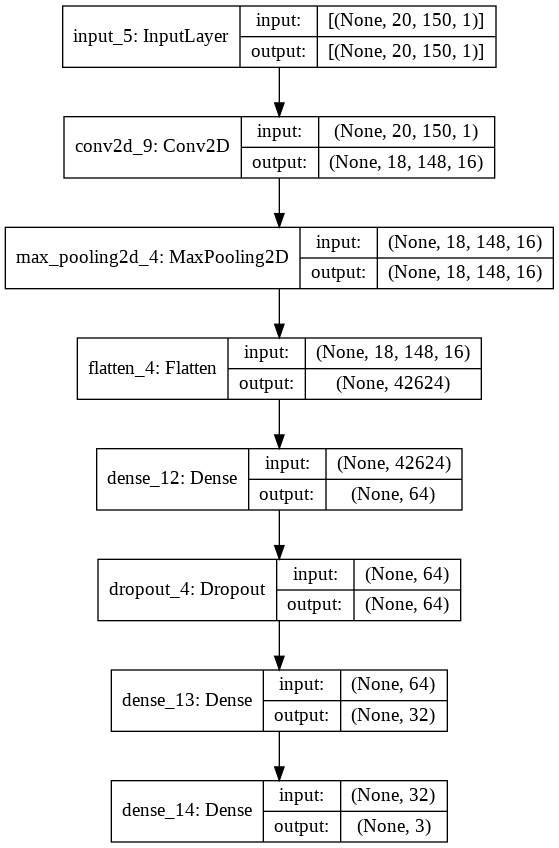

In [225]:
def inception_module(layer_in, f1, f2, f3):
	conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
	conv3 = Conv2D(f2, (3,3), padding='same', activation='relu')(layer_in)
	conv51 = Conv2D(f3, (3,3), padding='same', activation='relu')(layer_in)
	conv5 = Conv2D(f3, (3,3), padding='same', activation='relu')(conv51)
	pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
	layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
	return layer_out
 
visible = Input(shape=(wordnum,vectsize,1))
# convlayer = naive_inception_module(visible, 64, 64, 32)
conv1 = Conv2D(32, (3,6), activation='relu')(visible)
conv1 = Conv2D(16, (3,3), activation='relu')(visible)
pool1 = MaxPooling2D((3,3), strides=(1,1), padding='same')(conv1)
# inception = inception_module(pool1, 32, 64, 16)
# pool2 = MaxPooling2D((3,3), strides=(1,1), padding='same')(inception)
# gavgpool = GlobalAveragePooling2D()(pool2)
gavgpool = Flatten()(pool1)
dens1 = Dense(64, activation='relu')(gavgpool)
# dens2 = Dense(128, activation='relu')(dens1, activation='relu')
drop2 = Dropout(0.2)(dens1)
dens3 = Dense(32, activation='relu')(drop2)
dens4 = Dense(3, activation='sigmoid')(dens3)
model = Model(inputs=visible, outputs=dens4)

model.summary()
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

In [231]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
checkpoint = ModelCheckpoint('model.h5', verbose=1, monitor='val_accuracy',save_best_only=True,save_weights_only=True, mode='auto')  
with tf.device('/device:GPU:0'):
  start_time = time.time()
  history = model.fit(x=X_train,y = y_train,validation_split=0.2 ,epochs=25,batch_size =1000,callbacks=[checkpoint])
  print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/25
32/32 [==============================] - 2s 49ms/step - loss: 0.6085 - accuracy: 0.7665 - val_loss: 0.5439 - val_accuracy: 0.7874

Epoch 00001: val_accuracy improved from -inf to 0.78737, saving model to model.h5
Epoch 2/25
32/32 [==============================] - 1s 39ms/step - loss: 0.5732 - accuracy: 0.7758 - val_loss: 0.5536 - val_accuracy: 0.7878

Epoch 00002: val_accuracy improved from 0.78737 to 0.78775, saving model to model.h5
Epoch 3/25
32/32 [==============================] - 1s 40ms/step - loss: 0.5631 - accuracy: 0.7813 - val_loss: 0.5503 - val_accuracy: 0.7878

Epoch 00003: val_accuracy did not improve from 0.78775
Epoch 4/25
32/32 [==============================] - 1s 40ms/step - loss: 0.5666 - accuracy: 0.7768 - val_loss: 0.5408 - val_accuracy: 0.7879

Epoch 00004: val_accuracy improved from 0.78775 to 0.78787, saving model to model.h5
Epoch 5/25
32/32 [==============================] - 1s 40ms/step - loss: 0.5489 - accuracy: 0.7812 - val_loss: 0.5345 - val_a

Accuracy for Digikala = 0.7758
F1 score for Digikala = 0.3893745041342717


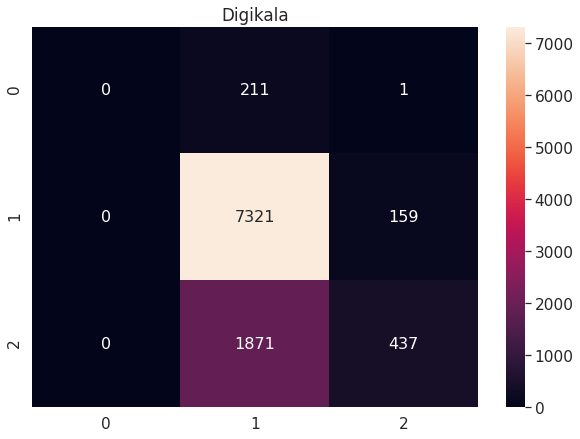

In [245]:
predicted = model.predict(X_test)
y_pred = np.argmax(predicted,1)
y_tested = np.argmax(y_test,1)
evaluation(y_tested,y_pred,'CNN',"Digikala")